# reaction-network (Demo Notebook): Networks

### Author: Matthew McDermott
Last Updated: 12/12/21

The code provided in this notebook is an updated walkthrough of the first example (YMnO3) in the accompanying manuscript (see citation below). The refactored `reaction-network` package contains similar code to what was released with the manuscript; however, many processes/functions are now separated into their own defined classes/methods. For a look at the previous demo notebook (which also contained some of the raw results that went into the manuscript), please check out the _archived_ folder.

**If you use this code or Python package in your work, please consider citing the following paper:**

McDermott, M. J., Dwaraknath, S. S., and Persson, K. A. (2021). A graph-based network for predicting chemical reaction pathways in solid-state materials synthesis. 
Nature Communications, 12(1). https://doi.org/10.1038/s41467-021-23339-x

### Imports

In [1]:
import logging 

from pymatgen.ext.matproj import MPRester
from rxn_network.enumerators.basic import BasicEnumerator, BasicOpenEnumerator
from rxn_network.enumerators.minimize import MinimizeGibbsEnumerator, MinimizeGrandPotentialEnumerator
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDPlotter
from rxn_network.thermo.chempot_diagram import ChemicalPotentialDiagram

from rxn_network.costs.softplus import Softplus
from pymatgen.core.composition import Composition, Element
from rxn_network.entries.entry_set import GibbsEntrySet
from rxn_network.network.network import ReactionNetwork
from rxn_network.entries.nist import NISTReferenceEntry
from rxn_network.reactions.computed import ComputedReaction
from rxn_network.reactions.reaction_set import ReactionSet
from rxn_network.reactions.open import OpenComputedReaction
from rxn_network.network.entry import NetworkEntry, NetworkEntryType
from rxn_network.network.visualize import plot_network_on_graphistry, plot_network
from rxn_network.pathways.solver import PathwaySolver

#import graphistry

%load_ext autoreload
%autoreload 2

logging.info("Logging initialized")

### Case Study: YMnO3 assisted metathesis

We will be using the assisted metathesis synthesis of YMnO3 as a case study for the reaction network code. This is the first example discussed in the original manuscript. The assisted metathesis reaction reported by Todd & Neilson (JACS, 2019) corresponds to a net reaction equation:

$$ Mn_2O_3 + 2 YCl_3 + 3Li_2CO_3 \to 2YMnO_3 + 6LiCl + 3CO_2 $$

In the paper, they report a reaction pathway involving the formation of intermediates LiMnO2 and YOCl. These react to form YMnO3 product and LiCl byproduct. (The CO2 is released when Li2CO3 reacts initially to form LiMnO2).

### Downloading and modifying entries

First, we acquire entries for phases in the Y-Mn-O-Li-Cl-C chemical system from the Materials Project (MP), a computed materials database containing calculations for over 130,000 materials.

In [2]:
with MPRester() as mpr:  # insert your Materials Project API key here if it's not stored in .pmgrc.yaml
    entries = mpr.get_entries_in_chemsys("C-Cl-Li-Mn-O-Y", inc_structure="final")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 848/848 [00:03<00:00, 223.92it/s]


The `GibbsEntrySet` class allows us to automatically converet `ComputedStructureEntry` objects downloaded from the MP database into `GibbsComputedEntry` objects, where DFT-calculated energies have been converted to machine learning (ML)-estimated equivalent values of the Gibbs free energies of formation, $\Delta G_f$ for all entries at the specified temperature. 

For more information, check out the citation in the documentation for `GibbsComputedEntry`.

In [3]:
temp = 900  # units: Kelvin
entry_set = GibbsEntrySet.from_entries(entries, temp, include_nist_data=True)

We can print the entries by calling `.entries` or `.entries_list`:

In [4]:
entry_set.entries

{GibbsComputedEntry | mp-1001581 | Li1 C6 (LiC6)
 Gibbs Energy (900 K) = -0.1809,
 GibbsComputedEntry | mp-1001594 | C48 O36 (C4O3)
 Gibbs Energy (900 K) = -57.1177,
 GibbsComputedEntry | mp-1001790 | Li1 O3 (LiO3)
 Gibbs Energy (900 K) = 0.1071,
 GibbsComputedEntry | mp-1002572 | Li4 Mn4 O8 (LiMnO2)
 Gibbs Energy (900 K) = -25.9343,
 GibbsComputedEntry | mp-1003313 | Li4 Mn6 O12 (Li2Mn3O6)
 Gibbs Energy (900 K) = -33.9276,
 GibbsComputedEntry | mp-1003315 | Li4 Mn16 O32 (LiMn4O8)
 Gibbs Energy (900 K) = -72.1966,
 GibbsComputedEntry | mp-1003549 | Li1 Mn16 O32 (LiMn16O32)
 Gibbs Energy (900 K) = -63.1448,
 GibbsComputedEntry | mp-1003637 | Li1 Mn3 O6 (LiMn3O6)
 Gibbs Energy (900 K) = -14.2671,
 GibbsComputedEntry | mp-1003769 | Li3 Mn4 O8 (Li3Mn4O8)
 Gibbs Energy (900 K) = -23.2175,
 GibbsComputedEntry | mp-1004373 | Li4 Mn4 O8 (LiMnO2)
 Gibbs Energy (900 K) = -10.5488,
 GibbsComputedEntry | mp-1004762 | Li2 Mn8 O16 (LiMn4O8)
 Gibbs Energy (900 K) = -35.5210,
 GibbsComputedEntry | mp-

The `GibbsEntrySet` class has many helpful functions, such as the following `filter_by_stability()` function, which automatically removes entries which are a specified energy per atom above the convex hull of stability:

In [5]:
entry_set = entry_set.filter_by_stability(0.01)
entry_set.entries_list

[GibbsComputedEntry | mp-569304 | C4 (C)
 Gibbs Energy (900 K) = 0.0000,
 GibbsComputedEntry | mp-1214283 | C40 Cl32 (C5Cl4)
 Gibbs Energy (900 K) = -2.6428,
 GibbsComputedEntry | mp-1214294 | C28 Cl32 (C7Cl8)
 Gibbs Energy (900 K) = -1.8844,
 GibbsComputedEntry | mp-1214421 | C64 Cl40 (C8Cl5)
 Gibbs Energy (900 K) = -2.7546,
 NISTReferenceEntry | CO2
 Gibbs Energy (900 K) = -4.1016,
 GibbsComputedEntry | mp-1008394 | Cl4 (Cl2)
 Gibbs Energy (900 K) = 0.0000,
 GibbsComputedEntry | mp-1018134 | Li3 (Li)
 Gibbs Energy (900 K) = 0.0000,
 GibbsComputedEntry | mp-531021 | Li11 Mn13 O32 (Li11Mn13O32)
 Gibbs Energy (900 K) = -84.5865,
 NISTReferenceEntry | Li2CO3
 Gibbs Energy (900 K) = -9.9542,
 GibbsComputedEntry | mp-765973 | Li8 Mn4 C8 O24 (Li2Mn(CO3)2)
 Gibbs Energy (900 K) = -73.5927,
 GibbsComputedEntry | mp-758215 | Li8 Mn4 C4 O16 (Li2MnCO4)
 Gibbs Energy (900 K) = -53.1006,
 GibbsComputedEntry | mp-18988 | Li8 Mn4 O12 (Li2MnO3)
 Gibbs Energy (900 K) = -40.0043,
 NISTReferenceEntry | 

In this case, we remove all non-stable entries from the entry set, which greatly reduces the combinatorial complexity of the system:

## Building the reaction network

The reaction network can be initialized by providing 3 arguments to the `ReactionNetwork` class:

1. **entries:** iterable of entry-like objects (e.g., `GibbsComputedEntry`)
2. **enumerators:** iterable of enumerators which will be called during the build of the network
3. **cost_function:** the function used to calculate the cost of each reaction edge 

We will use a BasicEnumerator (see the **Enumerators Demo Notebook** for more information on the type of enumerators available):

In [6]:
be = BasicEnumerator()

The cost function is a monotonic function used to assign weights to edges in the network. In this case, we will use the softplus function, assigned a temperature scaling of $T=900$ K, and use the default arguments which automatically determine the softplus weighting based on the energy per atom of the reaction:

In [7]:
cf = Softplus(900)

Finally, we provide these as arugments to the `ReactionNetwork` initialization:

In [8]:
rn = ReactionNetwork(entry_set, [be], cf)

This simply initializes a `ReactionNetwork` object but does not build the network graph. To do so, we call the `.build()` function:

In [9]:
rn.build()

Ray is not initialized. Trying with environment variables!
Could not identify existing Ray instance. Creating a new one...


2022-03-30 22:49:24,862	INFO services.py:1374 -- View the Ray dashboard at http://127.0.0.1:8266


[{'NodeID': '47d8759d8c7047054a10acfeb3b078ba6541d7840a0939a267736582', 'Alive': True, 'NodeManagerAddress': '127.0.0.1', 'NodeManagerHostname': 'macbook-pro-3.lan.dhcp.lbl.gov', 'NodeManagerPort': 59714, 'ObjectManagerPort': 59713, 'ObjectStoreSocketName': '/tmp/ray/session_2022-03-30_22-49-22_015565_53547/sockets/plasma_store', 'RayletSocketName': '/tmp/ray/session_2022-03-30_22-49-22_015565_53547/sockets/raylet', 'MetricsExportPort': 65531, 'alive': True, 'Resources': {'memory': 9977875662.0, 'CPU': 12.0, 'object_store_memory': 4988937830.0, 'node:127.0.0.1': 1.0}}]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:22<00:00,  2.50it/s]
INFO:ReactionNetwork:Building graph from reactions...


This should have completed within a few seconds. You'll notice that two things happened:

1. The enumerator(s) were run and a list of reactions was generated
2. The weighted graph object was built with these reactions and stored under the `graph` attribute of the reaction network object

We can access this graph object, which is a graph-tool object, by using the `graph` attribute:

In [10]:
rn.graph

<Graph object, directed, with 1288 vertices and 5652 edges, 2 internal vertex properties, 3 internal edge properties, at 0x14fb7a190>

There are a couple provided ways to plot reaction networks. The first is to use the built in drawing features in graph-tool, which have been provided in a wrapper function:

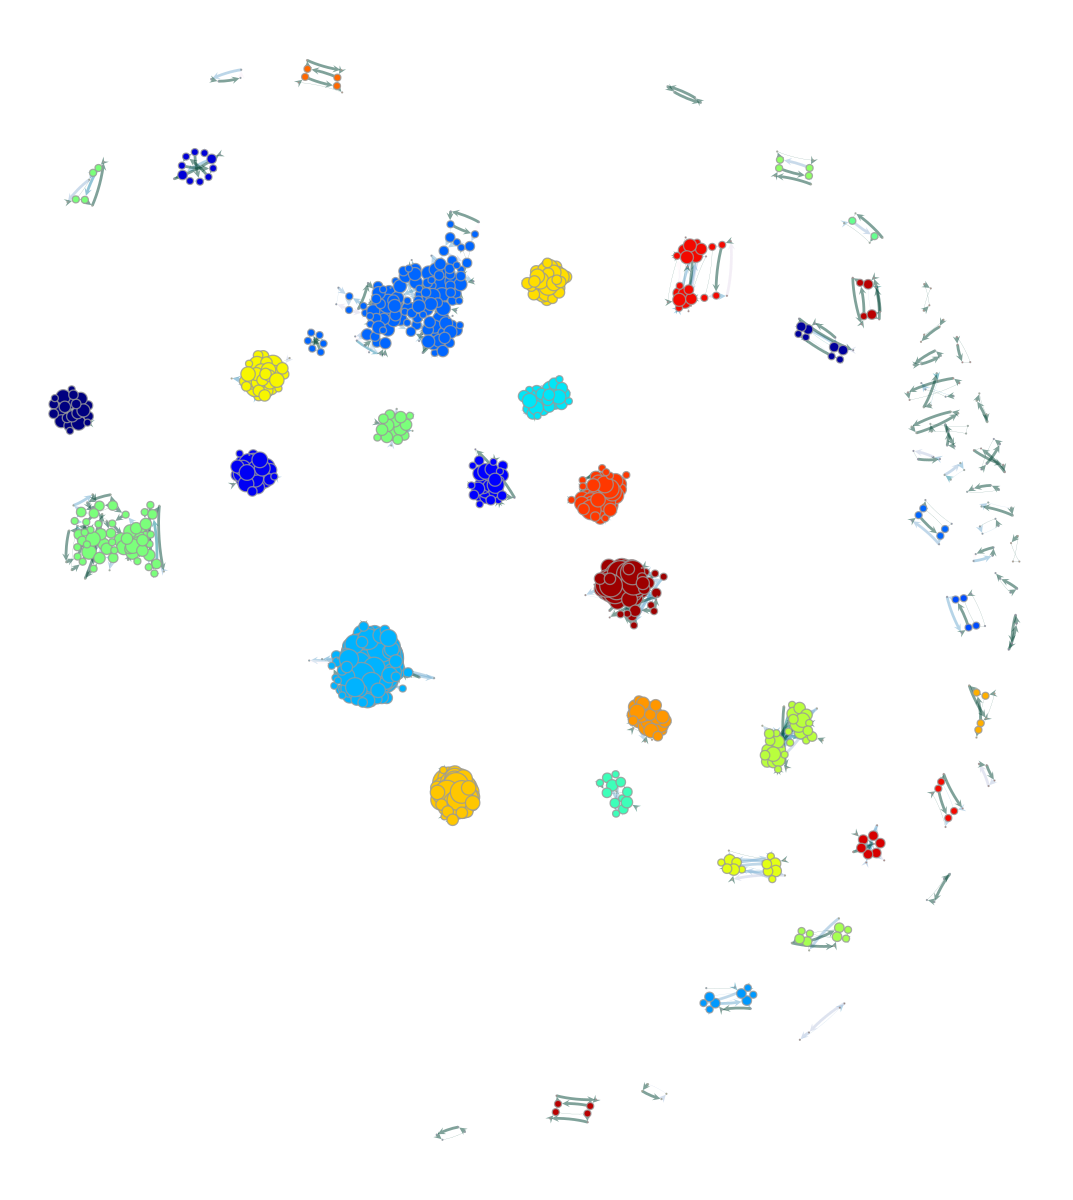

In [11]:
plot_network(rn.graph);

You'll notice that at this stage, the reaction network graph is a collection of "sub"-networks, i.e. a collection of smaller reaction networks for smaller chemical subsystems. This configuration will change once we set up for pathfinding in the next section.

The second way to plot graphs is to use graphistry, which requires setting up an account on Graphistry Hub: https://hub.graphistry.com/

In [13]:
#plot_network_on_graphistry(rn.graph)

### Solving for reaction pathways

To solve for reaction pathways, we must set precursor phases, as well as a target phase. This will automatically build all the required "zero-cost" edges which connect the different chemical subsystems. Please see the original manuscript for more detail with regards to how this works. In short, zero-cost edges are drawn between and product node to any reactant node that contains a subset of the set consisting of the {precursors + products} phases. 

In [14]:
rn.set_precursors([entry_set.get_min_entry_by_formula("Li2CO3"), 
                   entry_set.get_min_entry_by_formula("Mn2O3"), 
                   entry_set.get_min_entry_by_formula("YCl3")])

In [15]:
rn.set_target("YMnO3")

We can see how this changes the network by re-drawing it:

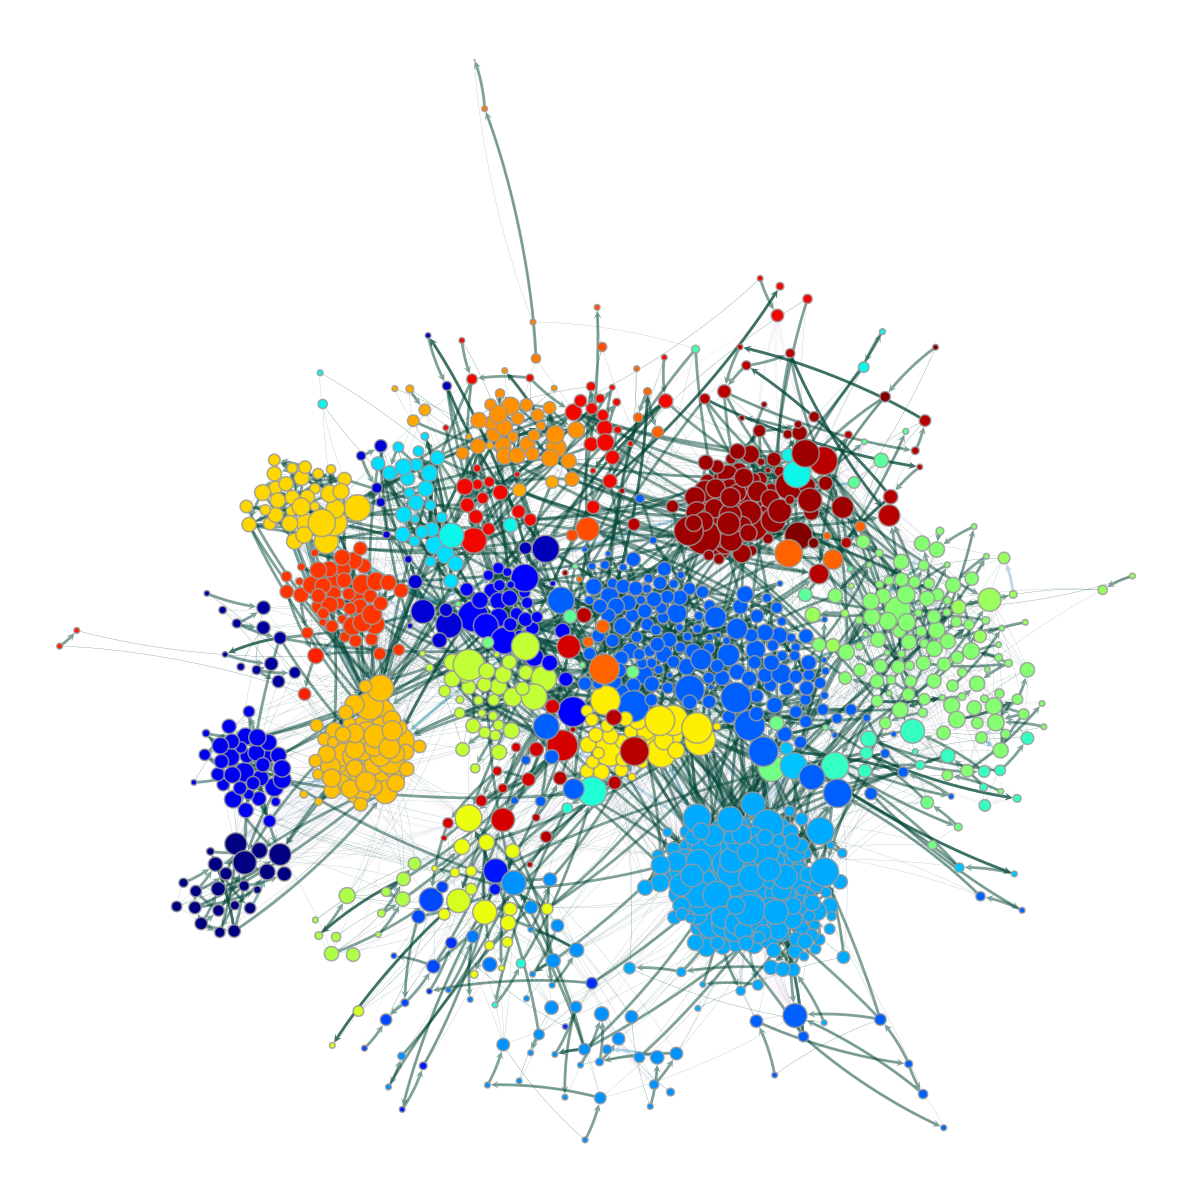

In [16]:
plot_network(rn.graph);

You should now see that the chemical subsystems have come together -- this is due to the zero-cost edges that were just described. We can now perform pathfinding to extract reaction pathways.

To get reaction pathways, we simply call the `find_pathways()` method. This automatically handles finding pathways to multiple targets, by calling the internal shortest paths method. The _k_ parameter specifies the number of shortest paths to find to each target.

In [17]:
paths = rn.find_pathways(["YMnO3", "LiCl", "CO2"], k=5)

PATHS to YMnO3 

--------------------------------------- 

1.5 Li2CO3 + 0.5 Mn2O3 -> Li3MnO3 + 1.5 CO2 (dG = 0.082 eV/atom) 
Li3MnO3 + YCl3 -> YMnO3 + 3 LiCl (dG = -0.218 eV/atom) 
Total Cost: 0.503 

2 Li2CO3 + Mn2O3 -> Li2Mn(CO3)2 + Li2MnO3 (dG = -0.054 eV/atom) 
3.429 Li2MnO3 + 3.286 Mn2O3 -> Li3MnO3 + 0.4286 Li9Mn21O40 (dG = 0.029 eV/atom) 
Li3MnO3 + YCl3 -> YMnO3 + 3 LiCl (dG = -0.218 eV/atom) 
Total Cost: 0.742 

2 Li2CO3 + Mn2O3 -> Li2Mn(CO3)2 + Li2MnO3 (dG = -0.054 eV/atom) 
3 Li2MnO3 + 2 Mn2O3 -> Li3MnO3 + 3 LiMn2O4 (dG = 0.035 eV/atom) 
Li3MnO3 + YCl3 -> YMnO3 + 3 LiCl (dG = -0.218 eV/atom) 
Total Cost: 0.744 

2 Li2CO3 + Mn2O3 -> Li2Mn(CO3)2 + Li2MnO3 (dG = -0.054 eV/atom) 
2.538 Li2MnO3 + 1.538 Mn2O3 -> Li3MnO3 + 0.2308 Li9Mn20O40 (dG = 0.05 eV/atom) 
Li3MnO3 + YCl3 -> YMnO3 + 3 LiCl (dG = -0.218 eV/atom) 
Total Cost: 0.748 

Li2CO3 + Mn2O3 -> MnCO3 + Li2MnO3 (dG = -0.021 eV/atom) 
3.429 Li2MnO3 + 3.286 Mn2O3 -> Li3MnO3 + 0.4286 Li9Mn21O40 (dG = 0.029 eV/atom) 
Li3MnO3 + YC

The output of this method is a list of `BasicPathway` objects. Note that these objects contain a list of reactions and associated costs, but the actual pathway is typically not balanced:

In [18]:
print(paths[5])

1.5 Li2CO3 + 0.5 Mn2O3 -> Li3MnO3 + 1.5 CO2 (dG = 0.082 eV/atom) 
Li3MnO3 + YCl3 -> YMnO3 + 3 LiCl (dG = -0.218 eV/atom) 
Total Cost: 0.503


This means that the reactions you see above do not necessarily include all reactants, nor do they include form all desired products. They are simply a series of reactions extracted from the reaction network that maybe encountered as the system attempts to get from starter phases to target phases.

To actually get balanced reactions, we can use the `PathwaySolver` class. This class takes a set of entries, a list of `BasicPathway` objects, as well as a cost function, and can be used to solve for balanced pathways given a net reaction. First we initialize the class:

In [24]:
ps = PathwaySolver(rn.entries, paths, Softplus(900)) # open_elem="O", chempot=0

ERROR! Session/line number was not unique in database. History logging moved to new session 2996


To balance the pathways, we must provide a net reaction representing the total conversion of precursors to final products. This corresponds to the assisted metathesis reaction we defined in the beginning. We can automatically make this reaction by initializing a `ComputedReaction` object from the corresponding entries:

In [25]:
product_entries = []
for i in ["YMnO3","LiCl","CO2"]:
    product_entries.append(entry_set.get_min_entry_by_formula(i))
    
net_rxn = ComputedReaction.balance(rn.precursors,product_entries)
net_rxn

1.5 Li2CO3 + YCl3 + 0.5 Mn2O3 -> YMnO3 + 3 LiCl + 1.5 CO2

Finally, we provide the net reaction to the `PathwaySolver` object. Note that the _intermediate_rxn_energy_cutoff_ helps to limit which intermediate reactions are considered (this can substantially decrease the combinatorial complexity), and the _filter_interdependent_ flag verifies that suggested pathways do not contain interdependnet reactions (i.e. where both the reactants of reaction A depend on the products of the reaction B, and the reactants of reaction B depend on the products of reaction A).

**Note: Even though this step is compiled/parallelized using Numba, this is often the most time-intensive step in the reaction network analysis. Consider limiting the value of the maximum number of combos, as well as the value of the intermediate reaction energy cutoff.**

In [26]:
balanced_paths = ps.solve(net_rxn, max_num_combos=5, 
                          intermediate_rxn_energy_cutoff=0.0, 
                          use_minimize_enumerator=True,
                          filter_interdependent=True)

INFO:PathwaySolver:NET RXN: 1.5 Li2CO3 + YCl3 + 0.5 Mn2O3 -> YMnO3 + 3 LiCl + 1.5 CO2 

INFO:PathwaySolver:Identifying reactions between intermediates...

  0%|                                                                                                                                                                                                   | 0/23 [00:00<?, ?it/s]

  0%|                                                                                                                                                                                                   | 0/27 [00:02<?, ?it/s]
INFO:PathwaySolver:Found 67 intermediate reactions!
OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
INFO:PathwaySolver:Solving for balanced pathways of size 4 ...

500000/1000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

8000000/8500000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [04:19<00:00, 15.24s/it]


We can now print the suggested, balanced reaction pathways:

In [27]:
for idx, path in enumerate(balanced_paths):
    print(f"Path {idx+1}", "\n")
    print(path)
    print("\n")

Path 1 

1.5 Li2CO3 + 0.5 Mn2O3 -> 1.5 CO2 + Li3MnO3 (dG = 0.082 eV/atom) 
Mn2O3 + Y2O3 -> 2 YMnO3 (dG = -0.048 eV/atom) 
LiMnO2 + YClO -> LiCl + YMnO3 (dG = -0.066 eV/atom) 
0.5 Li2CO3 + 0.5 YCl3 -> 0.5 CO2 + LiCl + 0.5 YClO (dG = -0.104 eV/atom) 
0.5 Li3MnO3 + 0.3333 YCl3 -> LiCl + 0.5 LiMnO2 + 0.1667 Y2O3 (dG = -0.177 eV/atom) 
Average Cost: 0.246


Path 2 

Mn2O3 + Y2O3 -> 2 YMnO3 (dG = -0.048 eV/atom) 
0.5 Li2CO3 + 0.5 YCl3 -> 0.5 CO2 + LiCl + 0.5 YClO (dG = -0.104 eV/atom) 
Li2CO3 + 2 YClO -> CO2 + 2 LiCl + Y2O3 (dG = -0.029 eV/atom) 
Average Cost: 0.246


Path 3 

1.5 Li2CO3 + 0.5 Mn2O3 -> 1.5 CO2 + Li3MnO3 (dG = 0.082 eV/atom) 
Mn2O3 + Y2O3 -> 2 YMnO3 (dG = -0.048 eV/atom) 
0.5 Li2CO3 + 0.5 YCl3 -> 0.5 CO2 + LiCl + 0.5 YClO (dG = -0.104 eV/atom) 
Li2CO3 + 2 YClO -> CO2 + 2 LiCl + Y2O3 (dG = -0.029 eV/atom) 
Li3MnO3 + 3 YClO -> 3 LiCl + Y2O3 + YMnO3 (dG = -0.107 eV/atom) 
Average Cost: 0.247


Path 4 

0.5 Li2CO3 + 0.5 Mn2O3 -> 0.5 CO2 + LiMnO2 (dG = 0.009 eV/atom) 
Mn2O3 + Y2O3

In [28]:
from rxn_network.pathways.pathway_set import PathwaySet

In [29]:
path_set = PathwaySet.from_paths(balanced_paths)

We note that **Pathway 12 most closely matches the experimentally observed reaction pathway** (ordering subject to change in the future).

However, many of the pathways include hypothetical (never-before-synthesized) materials (e.g., Li3MnO3), so the top-ranked pathway does not necessarily match what is experimentally observed.

### Running networks with Fireworks

The `NetworkFW` class allows you to easily run the reaction network construction and pathfinding analysis via fireworks. Simply create a network firework, add it to the LaunchPad, and launch it on your computing resource. See the documentation for more information about each of the parameters.

In [31]:
from fireworks import LaunchPad, Workflow
from rxn_network.fireworks.core import NetworkFW

/Users/mcdermott/opt/miniconda3/envs/rn_dev/lib/python3.9/site-packages/maggma/utils.py:20: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [33]:
lpad = LaunchPad.auto_load()

In [34]:
fw = NetworkFW([BasicEnumerator()], Softplus(900), chemsys="Y-Mn-O-Li-Cl-C", entry_set_params={"e_above_hull":0.000}, 
               pathway_params={"precursors":["YCl3","Mn2O3","Li2CO3"], "targets":["YMnO3","LiCl","CO2"], "k":5},
              solver_params={"max_num_combos":5, "intermediate_rxn_energy_cutoff":0.0, "use_minimize_enumerator": True})

In [35]:
lpad.add_wf(Workflow([fw]))

2022-03-30 23:15:06,694 INFO Added a workflow. id_map: {-1: 5773}


INFO:launchpad:Added a workflow. id_map: {-1: 5773}


{-1: 5773}

In [36]:
!rlaunch singleshot

2022-03-30 23:15:08,410 INFO Hostname/IP lookup (this will take a few seconds)
2022-03-30 23:15:08,441 INFO Launching Rocket
2022-03-30 23:15:13,518 INFO RUNNING fw_id: 5773 in directory: /Users/mcdermott/PycharmProjects/reaction-network/notebooks
2022-03-30 23:15:13,673 INFO Task started: {{rxn_network.firetasks.build_inputs.EntriesFromDb}}.
2022-03-30 23:15:23,017 INFO Task completed: {{rxn_network.firetasks.build_inputs.EntriesFromDb}}
2022-03-30 23:15:23,066 INFO Task started: {{rxn_network.firetasks.run_calc.BuildNetwork}}.
Ray is not initialized. Trying with environment variables!
Could not identify existing Ray instance. Creating a new one...
2022-03-30 23:15:25,866	INFO services.py:1374 -- View the Ray dashboard at http://127.0.0.1:8267
[{'NodeID': 'e3c9b3594801d4d004042a3a584e11fa271b9b05436c355e84683cdf', 'Alive': True, 'NodeManagerAddress': '127.0.0.1', 'NodeManagerHostname': 'macbook-pro-3.lan.dhcp.lbl.gov', 'NodeManagerPort': 60333, 'ObjectManagerPort': 60332, 'ObjectStore

### Thank you!

If any errors with the reaction-network code are encountered, please raise an Issue here: https://github.com/GENESIS-EFRC/reaction-network/issues

In [75]:
from maggma.stores import MongoStore
from rxn_network.pathways.pathway_set import PathwaySet

In [76]:
ms = MongoStore.from_db_file("/Users/mcdermott/db_rn.json")
ms.connect()

In [77]:
d = ms.query_one({"task_id":82}, ["balanced_pathways"])

In [78]:
pset = PathwaySet.from_dict(d["balanced_pathways"])